## Evaluation of the models (GAN and ViT)

#### Data

This study utilized three datasets: NEX-GDDP-CMIP6 as a baseline, the Global Meteorological Forcing Dataset (GMFD) for Land Surface Modeling as an observational dataset, and CMIP6 as the target general circulation model (GCM) data to be downscaled. In the study, a spatial subset of the aforementioned datasets was used, covering the geographical limits of 40.99986 to 51.49986 in latitude and 6.69986 to 30.99986 in longitude.


#### Methods

[**GAN:**](https://github.com/alexdum/downscale/blob/main/python/gan_02_all_residuals_time_alt.ipynb) adopted from https://journals.ametsoc.org/view/journals/aies/3/2/AIES-D-23-0066.1.xml.

[**ViT (Vision Transformer)**](https://github.com/alexdum/downscale/blob/main/python/vit_transformers_02_psl_residuals_time.ipynb) This configuration features multi-scale convolutional patch embedding with residual connections, followed by a series of transformer blocks. The model processes input data to generate an output with the same spatial dimensions, applying learnable positional encodings and a final dense layer for regression (https://arxiv.org/pdf/2410.12728).

Models were trained on historical data using air temperature and sea-level pressure as a predictors, and residuals (observational - cmip6) as the target variable. Estimated residuals were added back to bilinearly interpolated CMIP6 data (resampled to the observational data's spatial resolution) to evaluate models' performance.

The data fromMIROC6 for historical and SSP585 scenario. 
The historical data were split using as follows: training from 1950-2004, validation from 2004-2009, and testing from 2010-2014.


#### Define Functions for data loading and plotting

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')
import xarray as xr
import numpy as np
import seaborn as sns

import xarray as xr
import numpy as np
import dask

def load_and_mean_data(files_or_path, var_name, start_year=None, end_year=None, mask=None, lat=None, lon=None, interp_method=None, is_zarr=False):
    """
    Loads data from files, performs time-based calculations, and applies spatial operations.

    Args:
        files_or_path (str or list): Path to files or directory containing files.
        var_name (str): Name of the variable to process.
        start_year (int, optional): Start year for time selection. Defaults to None.
        end_year (int, optional): End year for time selection. Defaults to None.
        mask (xr.DataArray, optional): Mask to apply. Defaults to None.
        lat (np.ndarray, optional): Target latitude values for interpolation. Defaults to None.
        lon (np.ndarray, optional): Target longitude values for interpolation. Defaults to None.
        interp_method (str, optional): Interpolation method. Defaults to None.
        is_zarr (bool, optional): Whether the data is in zarr format. Defaults to False.

    Returns:
        xr.DataArray: Processed data.
    """

    if is_zarr:
        ds = xr.open_zarr(files_or_path, consolidated=True)
    else:
        ds = xr.open_mfdataset(files_or_path, combine='by_coords', chunks={'time': -1})

    # Select time range based on start and end years
    if 'time' in ds.coords and hasattr(ds.time.dt, 'year'):
        if start_year is not None:
            ds = ds.sel(time=ds.time.dt.year >= start_year)
        if end_year is not None:
            ds = ds.sel(time=ds.time.dt.year <= end_year)
    elif start_year is not None or end_year is not None:
        print("Warning: start_year and end_year provided, but 'time' coordinate not found or doesn't have a 'year' attribute. Ignoring year selection.")

    if var_name not in ["tas", "tas_downscaled", "tas_debiased"]:
        # Calculate total sum over all time and divide by number of years
        total_sum = ds[var_name].sum(dim='time', skipna=False)
        
        if 'time' in ds.coords and hasattr(ds.time.dt, 'year'):
            years = ds.time.dt.year # Get the DataArray of years
            # Corrected line: Use .values to get a NumPy array and then np.unique
            num_years = len(np.unique(years.values)) 
        else:
            num_years = 1 # if no time coordinate, assume one year.
            print("Warning: 'time' coordinate not found or doesn't have a 'year' attribute. Assuming 1 year.")
        
        data_mean = total_sum / num_years

    else:
        # Calculate mean over time
        data_mean = ds[var_name].mean(dim='time')

    # Interpolate if lat/lon are provided
    if lat is not None and lon is not None and interp_method:
        data_mean = data_mean.interp(lat=lat, lon=lon, method=interp_method, kwargs={"fill_value": "extrapolate"})

    # Apply mask if provided
    if mask is not None:
        data_mean = data_mean.where(~mask, np.nan)

    return data_mean

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Function to plot mean temperature maps
def plot_map(data, ax, title, mean_value, units='K', vmin=270, vmax=292, cmap='RdBu_r'):
 
    data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
        cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.8, 'aspect': 30, 'label': f' [{units}]'}  # Add units to colorbar label
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(title)
    ax.text(10, 50.5, f'Mean: {mean_value:.2f} {units}', fontsize=10, ha='center', va='center', color='black') # Add units to mean value text


# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted, roun = 3):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = round(np.sqrt(((actual_valid - predicted_valid) ** 2).mean()), roun)
    mae = round(np.abs(actual_valid - predicted_valid).mean(), roun)
    return rmse, mae

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_single_panel_boxplot(cmip6, nexgddp, gan, vit, months, gmfd=None, variable_name='Temperature'):
    """
    Creates a single-panel grouped boxplot comparing monthly distributions
    of a climate variable from different datasets (CMIP6, NEX-GDDP, GAN, ViT, and optionally GMFD).

    Args:
        cmip6 (xarray.Dataset or None): CMIP6 dataset (reference). Assumed to have 'tas' or 'pr'.
        nexgddp (xarray.Dataset or None): NEX-GDDP dataset. Assumed to have 'tas' or 'pr'.
        gan (xarray.Dataset or None): GAN downscaled dataset. Assumed to have 'tas_downscaled' or 'pr_downscaled'.
        vit (xarray.Dataset or None): ViT downscaled dataset. Assumed to have 'tas_downscaled' or 'pr_downscaled'.
        months (list): List of month names (e.g., ['Jan', 'Feb', ..., 'Dec']) corresponding to months 1-12.
        gmfd (xarray.Dataset or None, optional): GMFD dataset. Assumed to have 'tas' or 'pr'. Defaults to None.
        variable_name (str, optional): The variable to plot ('Temperature' or 'Precipitation'). Defaults to 'Temperature'.

    Raises:
        ValueError: If variable_name is not 'Temperature' or 'Precipitation'.
        ValueError: If no valid datasets are provided.
    """

    if variable_name not in ['Temperature', 'Precipitation']:
        raise ValueError("variable_name must be either 'Temperature' or 'Precipitation'")

    # Determine variable column names and plot labels based on variable_name
    if variable_name == 'Temperature':
        var_col_name_cmip6_nex_gmfd = 'tas'  # Assuming GMFD uses same name as CMIP6/NEX
        var_col_name_gan_vit = 'tas_downscaled'
        y_label = 'Temperature [°K]'
        title_prefix = 'Monthly Temperature'
    elif variable_name == 'Precipitation':
        var_col_name_cmip6_nex_gmfd = 'pr'   # Assuming GMFD uses same name as CMIP6/NEX
        var_col_name_gan_vit = 'pr_downscaled'
        y_label = 'Precipitation [mm]' # Adjust unit if needed
        title_prefix = 'Monthly Precipitation'

    # --- Data Processing ---
    datasets_to_process = {
        'CMIP6': (cmip6, var_col_name_cmip6_nex_gmfd),
        'GMFD': (gmfd, var_col_name_cmip6_nex_gmfd), # Add GMFD here
        'NEX-GDDP': (nexgddp, var_col_name_cmip6_nex_gmfd),
        'GAN': (gan, var_col_name_gan_vit),
        'ViT': (vit, var_col_name_gan_vit)
        
    }

    processed_dfs = []
    valid_models = [] # Keep track of models that were actually processed

    for model_name, (dataset, var_col_name) in datasets_to_process.items():
        if dataset is not None:
            try:
                df = dataset.to_dataframe().reset_index()
                # Check if the expected variable column exists
                if var_col_name not in df.columns:
                     print(f"Warning: Column '{var_col_name}' not found in dataset for model '{model_name}'. Skipping this dataset.")
                     continue # Skip this dataset if column is missing

                df = df.rename(columns={var_col_name: 'data_variable'})
                df['Model'] = model_name
                processed_dfs.append(df[['time', 'data_variable', 'Model']]) # Select only needed columns
                valid_models.append(model_name)
            except Exception as e:
                print(f"Warning: Could not process dataset for model '{model_name}'. Error: {e}")


    if not processed_dfs:
        raise ValueError("No valid datasets provided or processed successfully.")

    # Concatenate all valid data into a single DataFrame
    combined_df = pd.concat(processed_dfs)

    # Extract year, month, and rename value column
    combined_df['time'] = pd.to_datetime(combined_df['time'])
    combined_df['Year'] = combined_df['time'].dt.year
    combined_df['Month'] = combined_df['time'].dt.month
    combined_df = combined_df.rename(columns={'data_variable': 'Value'})

    # Map month numbers to names using the provided list
    if len(months) != 12:
        print("Warning: 'months' list does not contain 12 names. Month mapping might be incorrect.")
    month_mapping = {i + 1: month_name for i, month_name in enumerate(months)}
    combined_df['Month Name'] = combined_df['Month'].map(month_mapping)

    # Ensure Month Name is categorical and ordered correctly
    combined_df['Month Name'] = pd.Categorical(combined_df['Month Name'], categories=months, ordered=True)

    # Drop rows with NaN values in essential columns to avoid plotting errors
    combined_df = combined_df.dropna(subset=['Value', 'Month Name'])
   

    # --- Plotting ---
    # Define the custom palette, including GMFD in greyscale
    full_palette = {
        'CMIP6':'#525252' , # Lighter grey for reference
        'GMFD': '#969696',  # Darker grey for GMFD
        'NEX-GDDP': 'green',
        'GAN': 'red',
        'ViT': 'blue'
        
    }
    # Filter palette to only include models present in the data
    custom_palette = {model: color for model, color in full_palette.items() if model in valid_models}
    # Ensure the hue order matches the valid models found
    hue_order = [model for model in full_palette if model in valid_models]


    plt.figure(figsize=(10, 6)) # Slightly wider figure
    sns.boxplot(
        data=combined_df,
        x='Month Name',
        y='Value',
        hue='Model',
        hue_order=hue_order, # Control the order in the legend and plot
        palette=custom_palette,
        flierprops=dict(marker='o', markersize=3, markerfacecolor='grey', markeredgecolor='grey', alpha=0.5) # Make fliers less prominent
    )

    # Customize the plot
    # plt.title(f'{title_prefix} Distributions by Model', fontsize=16) # Optional title
    plt.ylabel(y_label, fontsize=16)
    plt.xlabel('') # Keep x-axis label empty as months are clear
    plt.xticks(rotation=45, ha='right') # Improve rotation alignment
    plt.legend( fontsize=12, title_fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Make grid lines slightly less prominent
    plt.xticks(fontsize=14) # Adjust tick font sizes if needed
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import xarray as xr # Assuming inputs are xarray DataArrays

def plot_relative_change_pdfs(cmip6_relative_change: xr.DataArray,
                              nexgddp_relative_change: xr.DataArray,
                              vit_relative_change: xr.DataArray,
                              gan_relative_change: xr.DataArray,
                              *, # Make subsequent arguments keyword-only for clarity
                              title: str = 'Probability Density of Relative Precipitation Change\n(SSP245 2071-2100 vs Historical 1981-2010)',
                              xlabel: str = 'Relative Change in Precipitation (%)',
                              ylabel: str = 'Probability Density',
                              figsize: tuple = (10, 6),
                              percentile_range: tuple = (0.5, 99.5),
                              kde_bandwidth=None # Optional: Pass bandwidth to gaussian_kde
                             ):
    """
    Generates and plots Probability Density Functions (PDFs) for relative change
    data from different climate model datasets (CMIP6, NEX-GDDP, ViT, GAN).

    CMIP6 is plotted as a filled gray area, while the others are plotted as lines.

    Args:
        cmip6_relative_change (xr.DataArray): Xarray DataArray of relative change for CMIP6.
        nexgddp_relative_change (xr.DataArray): Xarray DataArray of relative change for NEX-GDDP.
        vit_relative_change (xr.DataArray): Xarray DataArray of relative change for ViT Downscaled.
        gan_relative_change (xr.DataArray): Xarray DataArray of relative change for GAN Downscaled.
        title (str, optional): Title for the plot.
                               Defaults to a standard precipitation change title.
        xlabel (str, optional): Label for the x-axis.
                                Defaults to 'Relative Change in Precipitation (%)'.
        ylabel (str, optional): Label for the y-axis.
                                Defaults to 'Probability Density'.
        figsize (tuple, optional): Figure size (width, height) in inches.
                                   Defaults to (10, 6).
        percentile_range (tuple, optional): The lower and upper percentiles (0-100) used
                                            to determine the plotting range, avoiding extreme outliers.
                                            Defaults to (0.5, 99.5).
        kde_bandwidth (float or str, optional): Bandwidth method for Gaussian KDE. If None,
                                                scipy default ('scott') is used. Can be scalar
                                                or a string like 'silverman'. Defaults to None.
    """
    print("Preparing data for PDF plotting...")

    # 1. Flatten data and remove NaNs and infinite values for PDF calculation
    data_cmip6 = cmip6_relative_change.values.flatten()
    data_cmip6 = data_cmip6[np.isfinite(data_cmip6)]

    data_nexgddp = nexgddp_relative_change.values.flatten()
    data_nexgddp = data_nexgddp[np.isfinite(data_nexgddp)]

    data_vit = vit_relative_change.values.flatten()
    data_vit = data_vit[np.isfinite(data_vit)]

    data_gan = gan_relative_change.values.flatten()
    data_gan = data_gan[np.isfinite(data_gan)]

    # Store datasets and check if any are empty after cleaning (important for KDE)
    datasets = {
        "CMIP6": data_cmip6,
        "NEX-GDDP": data_nexgddp,
        "ViT Downscaled": data_vit,
        "GAN Downscaled": data_gan
    }

    valid_datasets = {name: data for name, data in datasets.items() if data.size > 1} # KDE needs > 1 point

    if not valid_datasets:
        print("Error: No datasets have enough valid data points (>1) to calculate PDFs.")
        return # Exit function if no valid data

    print(f"Valid data points per dataset: { {name: len(data) for name, data in valid_datasets.items()} }")

    # 2. Determine a common plotting range based on valid data
    all_valid_data = np.concatenate(list(valid_datasets.values()))
    if all_valid_data.size == 0:
        print("Error: No valid finite data found in any dataset after filtering. Cannot plot.")
        return

    try:
        lower_perc, upper_perc = percentile_range
        if not (0 <= lower_perc < upper_perc <= 100):
             raise ValueError("Percentiles must be between 0 and 100, with lower < upper.")
        xmin = np.percentile(all_valid_data, lower_perc)
        xmax = np.percentile(all_valid_data, upper_perc)
    except ValueError as e:
         print(f"Warning: Invalid percentile range {percentile_range}. Using default 0.5, 99.5. Error: {e}")
         xmin = np.percentile(all_valid_data, 0.5)
         xmax = np.percentile(all_valid_data, 99.5)
    except IndexError:
        print("Error: Cannot calculate percentiles. Data might be empty.")
        return

    x_padding = (xmax - xmin) * 0.1
    if x_padding == 0:
        x_padding = 1 if xmax != 0 else 0.1

    x_eval = np.linspace(xmin - x_padding, xmax + x_padding, 300)
    print(f"Plotting PDF over range: {x_eval.min():.2f} to {x_eval.max():.2f}")

    # 3. Estimate PDFs using Kernel Density Estimation (KDE)
    kdes = {}
    for name, data in valid_datasets.items():
        try:
            kde = gaussian_kde(data, bw_method=kde_bandwidth)
            _ = kde(x_eval) # Evaluate once to catch potential numerical issues
            kdes[name] = kde
            print(f"Calculated KDE for {name}")
        except Exception as e:
            print(f"Warning: Could not calculate or evaluate KDE for {name}. Skipping. Error: {e}")

    # 4. Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Plot CMIP6 (filled gray) if its KDE was calculated
    if "CMIP6" in kdes:
        pdf_cmip6 = kdes["CMIP6"](x_eval)
        ax.plot(x_eval, pdf_cmip6, color='darkgray', linewidth=1.0, zorder=2)
        ax.fill_between(x_eval, pdf_cmip6, color='gray', alpha=0.6, label='CMIP6', zorder=1)
        print("Plotted CMIP6 PDF (filled gray).")

    # Plot other datasets as lines if their KDEs were calculated
    line_colors = {'NEX-GDDP': 'green', 'ViT Downscaled': 'blue', 'GAN Downscaled': 'red'}
    line_styles = {'NEX-GDDP': '-', 'ViT Downscaled': '--', 'GAN Downscaled': '-'}
    line_widths = {'NEX-GDDP': 1.5, 'ViT Downscaled': 1.8, 'GAN Downscaled': 1.5}
    z_orders = {'NEX-GDDP': 3, 'ViT Downscaled': 5, 'GAN Downscaled': 4}

    for name in ["NEX-GDDP", "ViT Downscaled", "GAN Downscaled"]:
         if name in kdes:
             pdf_data = kdes[name](x_eval)
             ax.plot(x_eval, pdf_data,
                     color=line_colors.get(name, 'black'),
                     linestyle=line_styles.get(name, '-'),
                     linewidth=line_widths.get(name, 1.5),
                     label=name,
                     zorder=z_orders.get(name, 3))
             print(f"Plotted {name} PDF (line).")

    # 5. Customize plot - USING ARGUMENTS for title and xlabel
    ax.set_xlabel(xlabel, fontsize=12) # Use function argument
    ax.set_ylabel(ylabel, fontsize=12) # Use function argument (already existed)
    ax.set_title(title, fontsize=14)   # Use function argument

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=10)
    else:
        print("Warning: No datasets were successfully plotted, skipping legend.")

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

   


# --- Example Usage ---
# Assuming the following variables exist and are xarray.DataArrays loaded previously:
# cmip6_relative_change
# nexgddp_relative_change
# vit_relative_change
# gan_relative_change

# # --- Call the function with custom title and xlabel ---
# custom_plot_title = "PDF of Relative Change in Variable 'X' (Future vs. Past)"
# custom_x_label = "Relative Change in 'X' (%)"

# plot_relative_change_pdfs(
#     cmip6_relative_change,
#     nexgddp_relative_change,
#     vit_relative_change,
#     gan_relative_change,
#     # Pass title and xlabel as keyword arguments
#     title=custom_plot_title,
#     xlabel=custom_x_label,
#     # Other optional arguments can also be passed
#     figsize=(11, 7),
#     percentile_range=(1, 99) # Use a slightly different range
# )
# print("Example usage finished.")
# ---------------------------------------------------------------------

## Air temperature

### Load and plot historical
Load the datasets (CMIP6, NEX-GDDP, GAN and ViT), calculate the multiannual means, and plot the results.

#### Historical

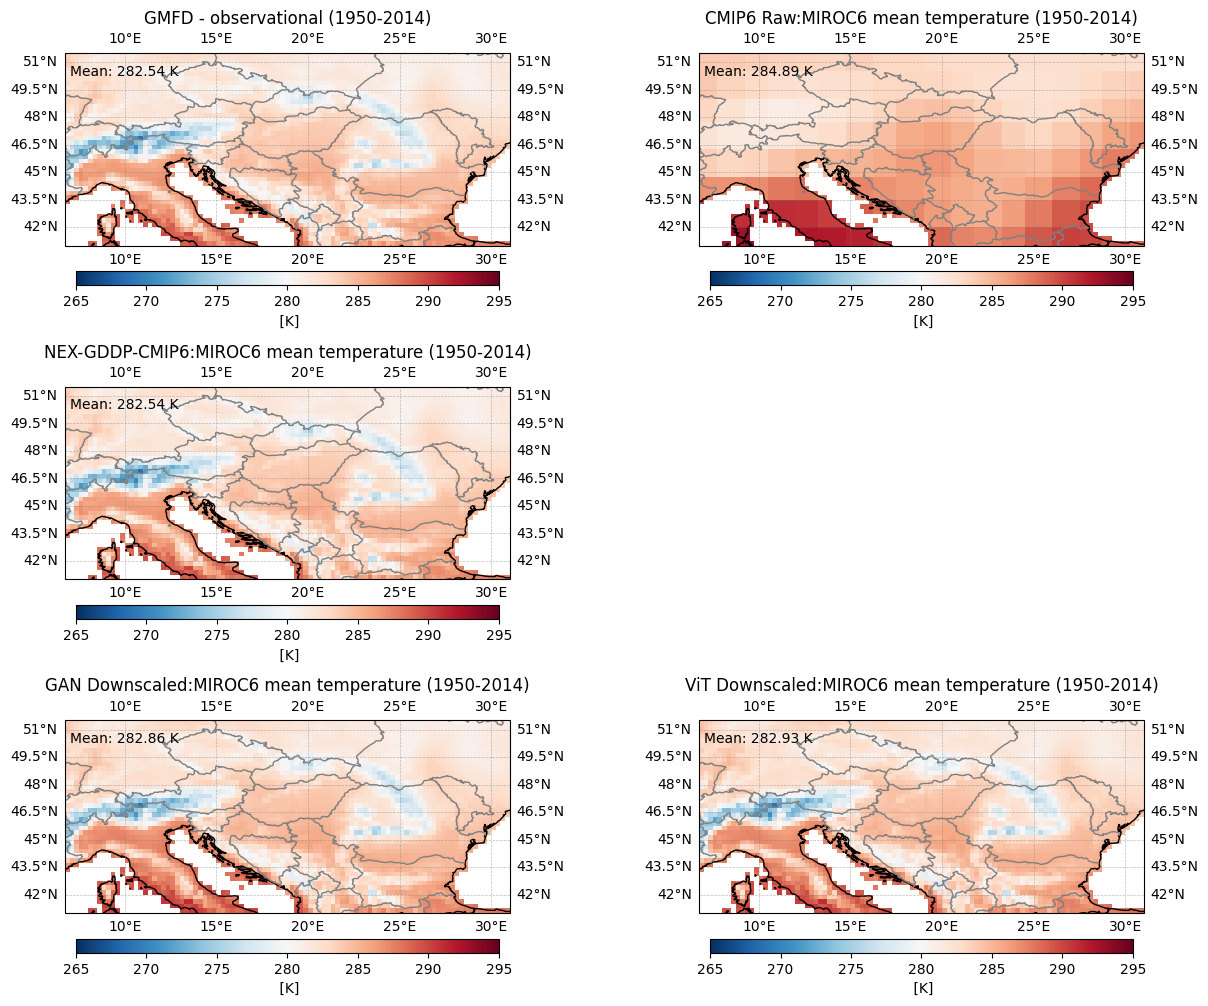

In [2]:
# Define file paths for historical data
nexgddp_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6'
cmip6_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/MIROC6'

nexgddp_hist_files = [f'{nexgddp_base_path}/historical/r1i1p1f1/tas/tas_day_MIROC6_historical_r1i1p1f1_gn_{year}_rou.nc' for year in range(1950, 2015)]
cmip6_hist_file = f'{cmip6_base_path}/historical/r1i1p1f1/tas/tas_day_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.zarr'

vit_hist_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/historical/r1i1p1f1/tas/tas_day_vit_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.nc'
gan_hist_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/historical/r1i1p1f1/tas/tas_day_gan_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.nc'

# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1950, end_year = 2014)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon


# Load CMIP6 data and interpolate
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1950, end_year = 2014)

# Load gan and ViT downscaled data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)
gan_mean_hist = load_and_mean_data(gan_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)


# Load GMFD observatinal data
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_mean_hist = load_and_mean_data(gmfd_files, 'tas', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)


# Plot multiannual means for historical data
fig, axs = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Plot each dataset for historical data
plot_map(gmfd_mean_hist, axs[0, 0], 'GMFD - observational (1950-2014)', gmfd_mean_hist.mean().values, vmin = 265, vmax = 295)
plot_map(cmip6_mean_hist, axs[0, 1], 'CMIP6 Raw:MIROC6 mean temperature (1950-2014)', cmip6_mean_hist.mean().values, vmin = 265, vmax = 295)
plot_map(gmfd_mean_hist, axs[1, 0], 'NEX-GDDP-CMIP6:MIROC6 mean temperature (1950-2014)', gmfd_mean_hist.mean().values, vmin = 265, vmax = 295)
axs[1, 1].set_axis_off()
plot_map(gan_mean_hist, axs[2, 0], 'GAN Downscaled:MIROC6 mean temperature (1950-2014)',gan_mean_hist.mean().values, vmin = 265, vmax = 295)
plot_map(vit_mean_hist, axs[2, 1], 'ViT Downscaled:MIROC6 mean temperature (1950-2014)', vit_mean_hist.mean().values, vmin = 265, vmax = 295)
# Leave axs[0, 1] empty as requested
plt.show()

#### Annual time serie plot

RMSE and MAE values:
NEX-GDDP: RMSE = 2.351, MAE = 2.349
GMFD: RMSE = 2.480, MAE = 2.343
GAN: RMSE = 2.032, MAE = 2.032
ViT: RMSE = 1.954, MAE = 1.954


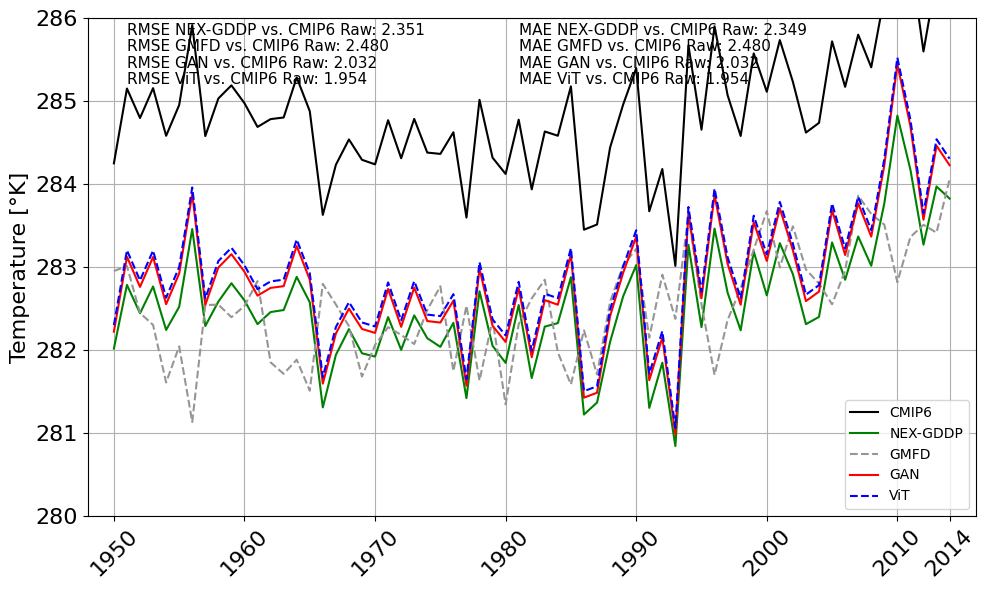

In [3]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_hist_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_hist_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load GMFD observatinal data
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_ds = xr.open_mfdataset(gmfd_files, combine='by_coords', chunks={'time': -1})
gmfd_annual = gmfd_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
gmfd_global_mean = gmfd_annual.mean(dim=['lat', 'lon'])


# Load and process gan data
gan_ds = xr.open_dataset(gan_hist_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_hist_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean,gmfd_global_mean, gan_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gmfd_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
                      calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values))

nexgddp_global_mean, cmip6_global_mean, gmfd_global_mean, gan_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gmfd, mae_gmfd), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"GMFD: RMSE = {rmse_gmfd:.3f}, MAE = {mae_gmfd:.3f}")
print(f"GAN: RMSE = {rmse_gan:.3f}, MAE = {mae_gan:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")


# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gmfd_global_mean.values, label='GMFD', color='#969696', linestyle='--')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('Historical - Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature [°K]', fontsize=16)
plt.legend()
plt.grid()
# Set tick font sizes
# Set specific x-axis ticks and font size
plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2014], rotation=45, fontsize=16)

plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [285.8, 285.6, 285.4, 285.2]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp,rmse_gmfd, rmse_gan, rmse_vit],
        [mae_nexgddp,rmse_gmfd, mae_gan, mae_vit],
        ['NEX-GDDP', 'GMFD', 'GAN', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(1951, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(1981, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(1951, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(1981, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(280, 287.5)
plt.xlim(1948,2016)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_hist_files) 
gmfd_monthly = load_and_process(gmfd_files) 
cmip6_monthly = load_and_process(cmip6_hist_file) 
gan_monthly = load_and_process(gan_hist_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_hist_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly,gmfd_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, gmfd_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
gmfd_global_mean_monthly = global_means[1]
nexgddp_global_mean_monthly = global_means[2]
gan_global_mean_monthly = global_means[3]
vit_global_mean_monthly = global_means[4]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GMFD RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GMFD MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_gmfd, mae_gmfd = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[4].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["GMFD RMSE"].append(rmse_gmfd)
    metrics["GMFD MAE"].append(mae_gmfd)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'GMFD RMSE', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'GMFD MAE', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

Table 1: Root Mean Squared Error (RMSE) by Model and Month
     Month          GMFD RMSE     NEX-GDDP RMSE     GAN RMSE        ViT RMSE   
     January         4.388           2.322           3.026           3.036     
    February         4.706           2.417           3.023           3.033     
       March         4.146           2.542           3.016           3.025     
       April         3.825           3.144           3.004           3.014     
         May         4.369           3.919           3.002           3.011     
        June         5.539           5.369           3.017           3.027     
        July         6.270           5.953           3.044           3.054     
      August         5.342           4.979           3.041           3.050     
   September         4.312           3.467           3.013           3.023     
     October         3.446           2.451           3.001           3.010     
    November         3.448           2.280           3.007   

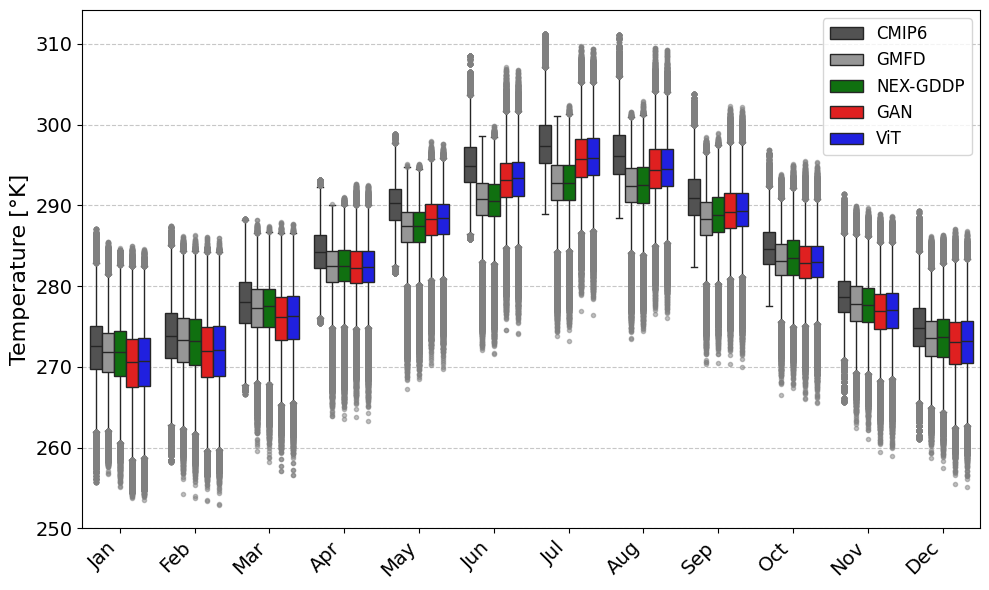

In [5]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[2],
    datasets[3],
    datasets[4],
    month_names,
    gmfd = datasets[1],
)

### SSP 126

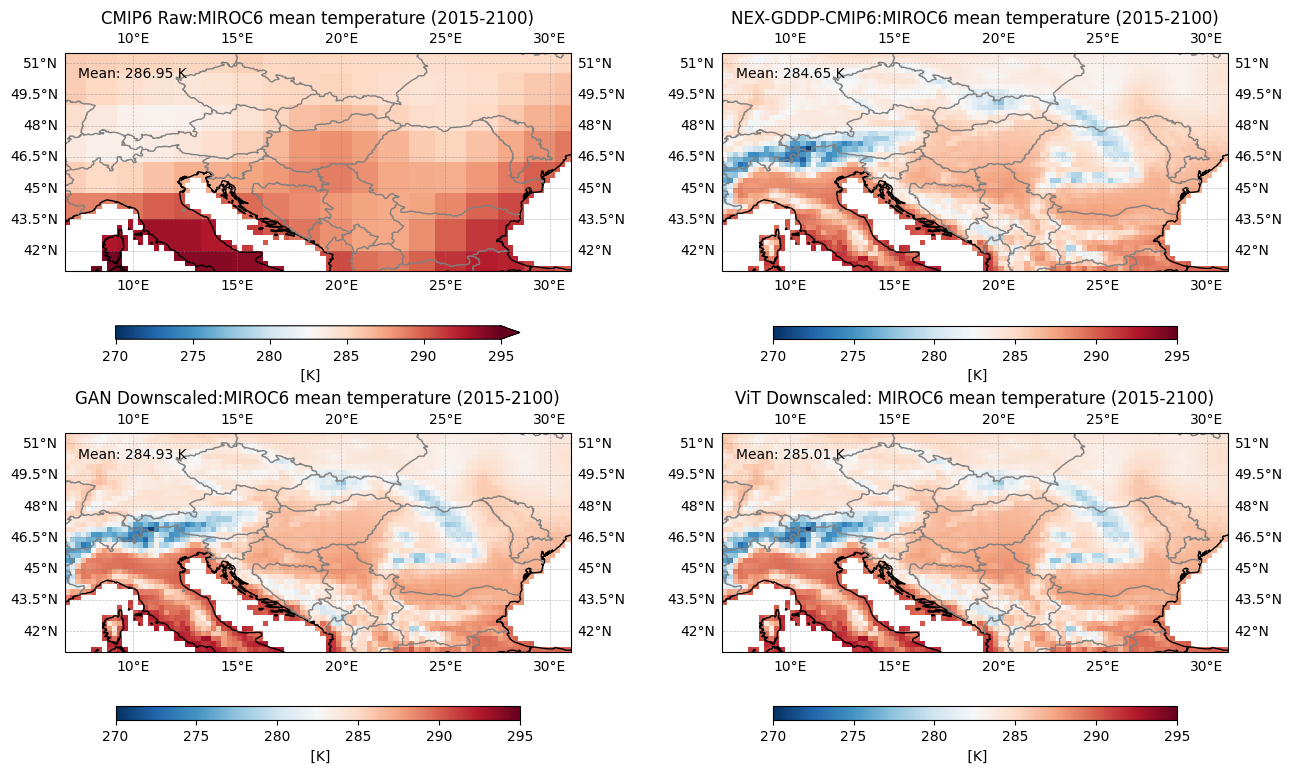

In [6]:
directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6/ssp126/r1i1p1f1/tas/'
# List all .nc files in the directory (non-recursive)
nexgddp_ssp_files  = glob.glob(f'{directory}/*.nc')
cmip6_ssp_file = f'{cmip6_base_path}/ssp126/r1i1p1f1/tas/tas_day_MIROC6_ssp126_r1i1p1f1_gr_2015_2100_rou.zarr'

vit_ssp_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp126/r1i1p1f1/tas/tas_day_vit_MIROC6_ssp126_r1i1p1f1_gr_2015_2100_rou.nc'
gan_ssp_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp126/r1i1p1f1/tas/tas_day_gan_MIROC6_ssp126_r1i1p1f1_gr_2015_2100_rou.nc'

# Load NEX-GDDP SSP126 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP126 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load gan and ViT downscaled data for SSP126
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP126 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw:MIROC6 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values, vmin = 270, vmax = 295)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6:MIROC6 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values, vmin = 270, vmax = 295)
plot_map(gan_mean_ssp, axs[1, 0], 'GAN Downscaled:MIROC6 mean temperature (2015-2100)', gan_mean_ssp.mean().values, vmin = 270, vmax = 295)
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled: MIROC6 mean temperature (2015-2100)', vit_mean_ssp.mean().values, vmin = 270, vmax = 295)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

#### Climate change signal

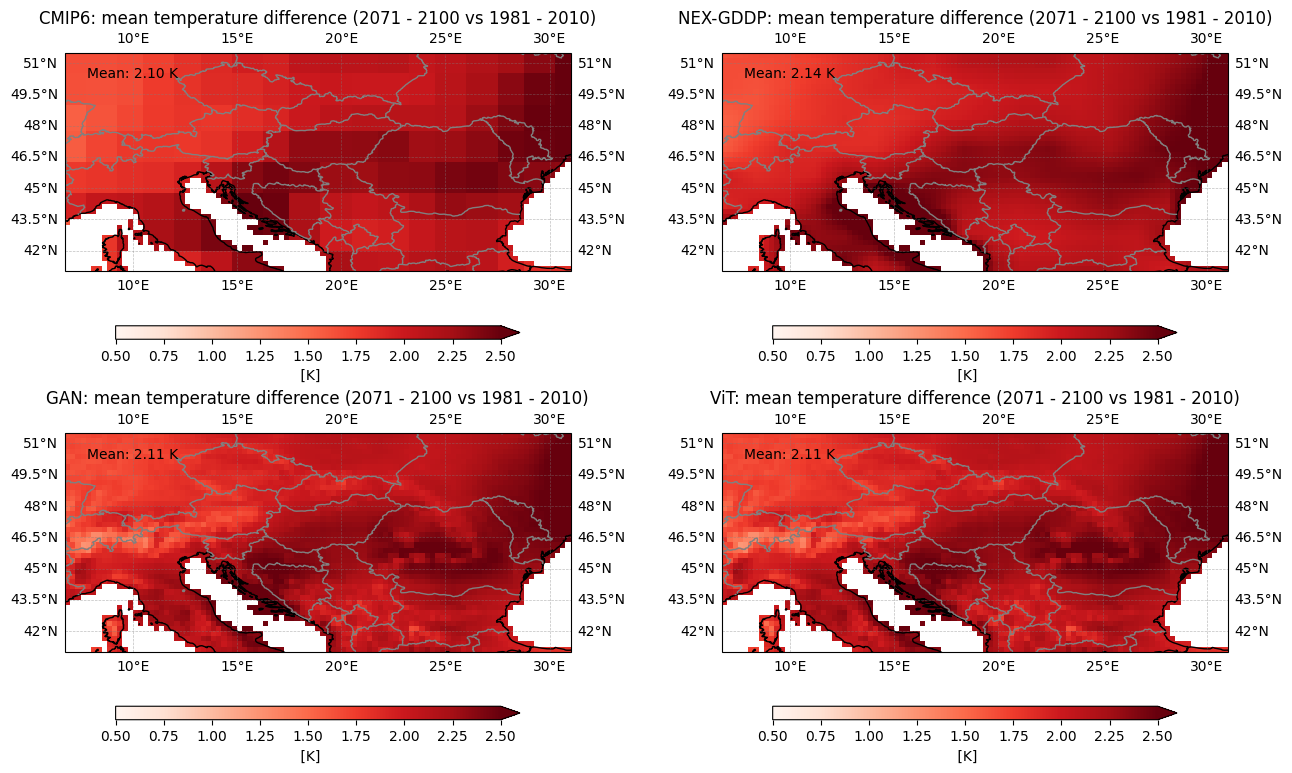

In [7]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon

# Load CMIP6 data and interpolate to observational resolution
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)

# Load gan and ViT downscaled historical data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
gan_mean_hist = load_and_mean_data(gan_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load gan and Vit downscaled data for SSP245
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
gan_mean_change = gan_mean_ssp - gan_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=0.5, vmax=2.5, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=0.5, vmax=2.5, cmap='Reds')
plot_map(gan_mean_change, axs[1, 0], 'GAN: mean temperature difference (2071 - 2100 vs 1981 - 2010)', gan_mean_change.mean().values, vmin=0.5, vmax=2.5, cmap='Reds')
plot_map(vit_mean_change, axs[1, 1], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=0.5, vmax=2.5, cmap='Reds')

#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

Preparing data for PDF plotting...
Valid data points per dataset: {'CMIP6': 3611, 'NEX-GDDP': 3611, 'ViT Downscaled': 3611, 'GAN Downscaled': 3611}
Plotting PDF over range: 1.47 to 2.74
Calculated KDE for CMIP6
Calculated KDE for NEX-GDDP
Calculated KDE for ViT Downscaled
Calculated KDE for GAN Downscaled
Plotted CMIP6 PDF (filled gray).
Plotted NEX-GDDP PDF (line).
Plotted ViT Downscaled PDF (line).
Plotted GAN Downscaled PDF (line).


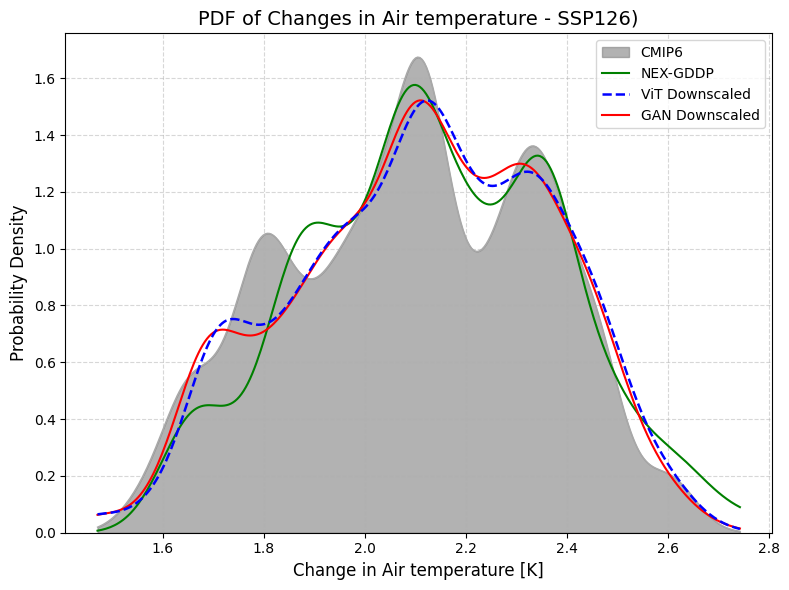

In [8]:

# --- Example Usage ---
#Assuming the following variables exist and are xarray.DataArrays loaded previously:
cmip6_change
nexgddp_mean_change
vit_mean_change
gan_mean_change

# --- Call the function with custom title and xlabel ---
custom_plot_title = "PDF of Changes in Air temperature - SSP126)"
custom_x_label = "Change in Air temperature [K]"

plot_relative_change_pdfs(
    cmip6_change,
    nexgddp_mean_change,
    vit_mean_change,
    gan_mean_change,
    # Pass title and xlabel as keyword arguments
    title=custom_plot_title,
    xlabel=custom_x_label,
    # Other optional arguments can also be passed
    figsize=(8, 6),
    percentile_range=(1, 99) # Use a slightly different range
)

#### Annual time serie plot

RMSE and MAE values:
NEX-GDDP: RMSE = 2.299, MAE = 2.298
GAN: RMSE = 2.019, MAE = 2.019
ViT: RMSE = 1.936, MAE = 1.936


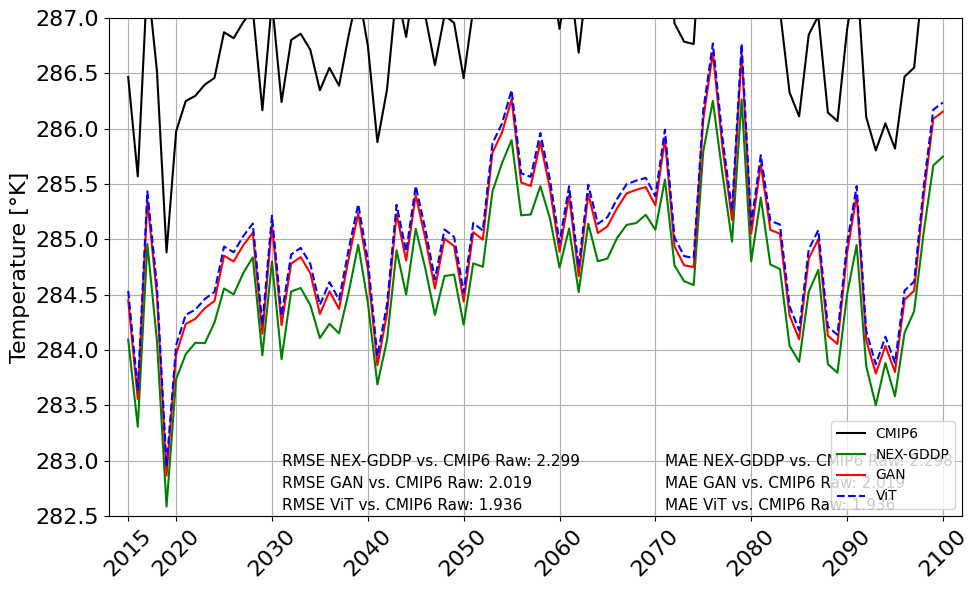

In [9]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load and process gan data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
                      calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values))

nexgddp_global_mean, cmip6_global_mean, gan_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"GAN: RMSE = {rmse_gan:.3f}, MAE = {mae_gan:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")


# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('Historical - Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature [°K]', fontsize=16)
plt.legend()
plt.grid()
# Set tick font sizes
# Set specific x-axis ticks and font size
plt.xticks(ticks=[2015, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], rotation=45, fontsize=16)

plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [282.95, 282.75, 282.55]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP', 'GAN', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2031, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2071, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2031, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2071, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(282.5, 289)
plt.xlim(2013,2102)
plt.tight_layout()
plt.show()

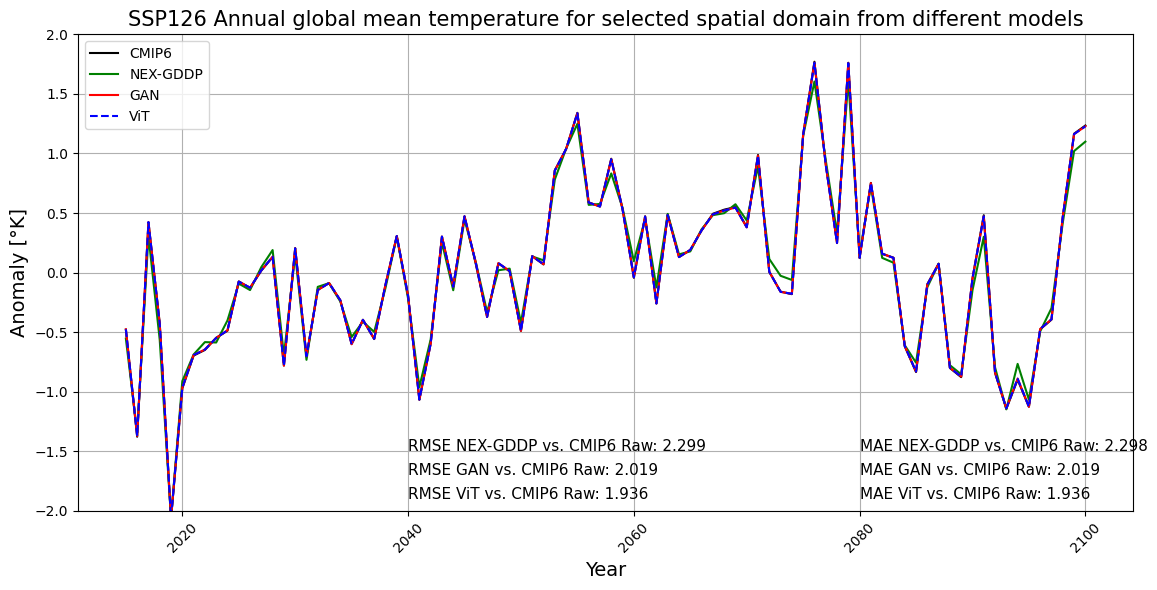

In [10]:


plt.figure(figsize=(12, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values - cmip6_global_mean.values.mean(), label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values - nexgddp_global_mean.values.mean(), label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values - gan_global_mean.values.mean(), label='GAN', color='red')
plt.plot(years, vit_global_mean.values - vit_global_mean.values.mean(), label='ViT', color='blue', linestyle='--')

# Customize the plot
plt.title('SSP126 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Anomaly [°K]', fontsize=14)
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Adjust text_y_positions to have enough elements
text_y_positions = [ -1.5, - 1.7, - 1.9]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP', 'GAN', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2040, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2080, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2040, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2080, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()



#### Print accuracy indicators

In [11]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
cmip6_monthly = load_and_process(cmip6_ssp_file) 
gan_monthly = load_and_process(gan_ssp_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
gan_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

Table 1: Root Mean Squared Error (RMSE) by Model and Month
     Month        NEX-GDDP RMSE     GAN RMSE        ViT RMSE   
     January         2.340           3.054           3.067     
    February         2.437           3.056           3.069     
       March         2.505           3.045           3.058     
       April         3.055           3.037           3.050     
         May         3.826           3.041           3.054     
        June         5.283           3.072           3.084     
        July         5.931           3.109           3.121     
      August         4.887           3.102           3.114     
   September         3.373           3.060           3.072     
     October         2.392           3.037           3.050     
    November         2.309           3.043           3.056     
    December         2.486           3.049           3.062     

Table 2: Mean Absolute Error (MAE) by Model and Month
     Month        NEX-GDDP MAE       GAN MAE         V

#### Boxplots

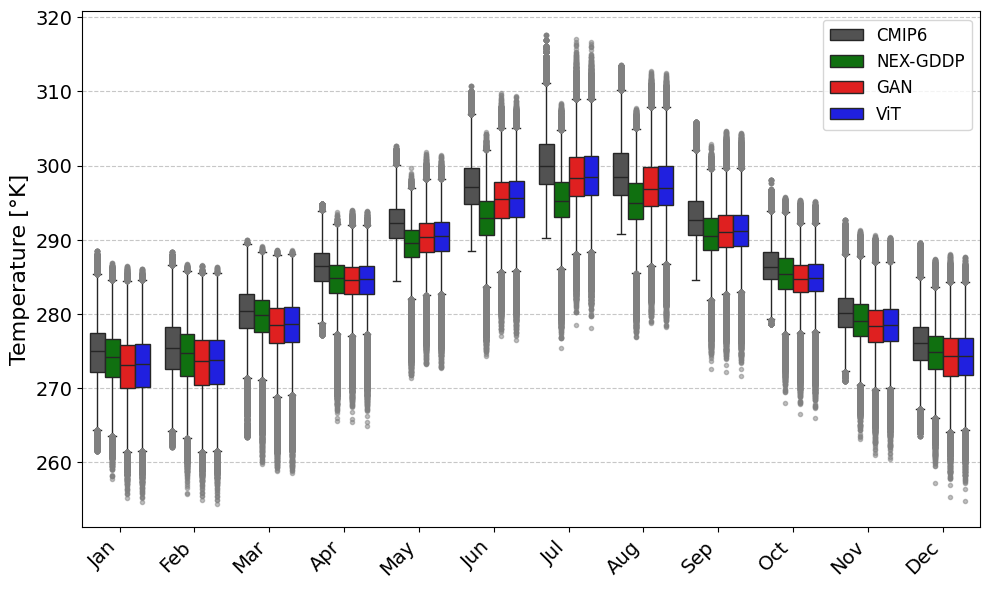

In [12]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[1],
    datasets[2],
    datasets[3],
    month_names,
    gmfd = None
)

#### Time series plots for January and July

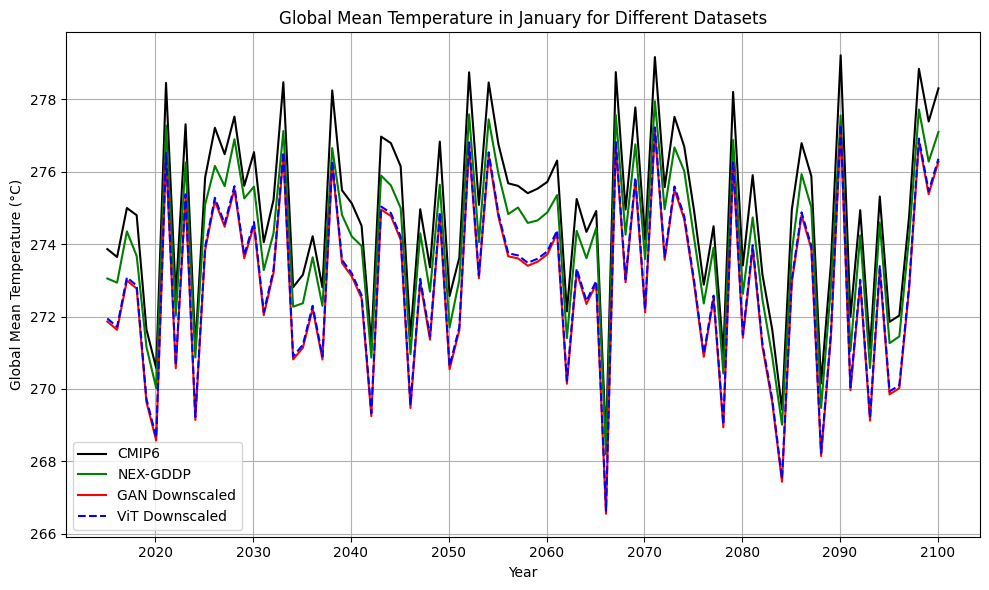

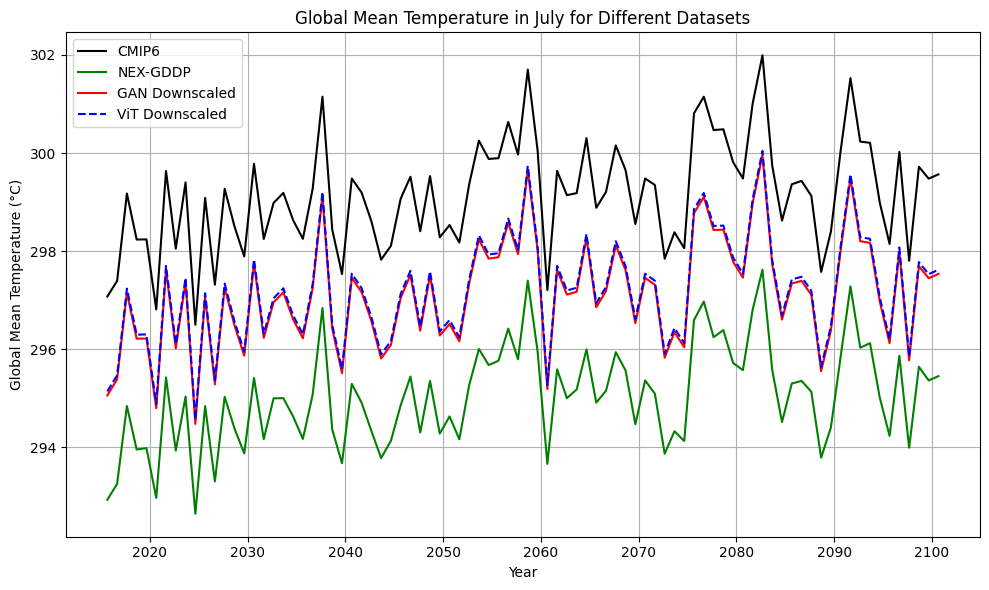

In [13]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### SSP 245

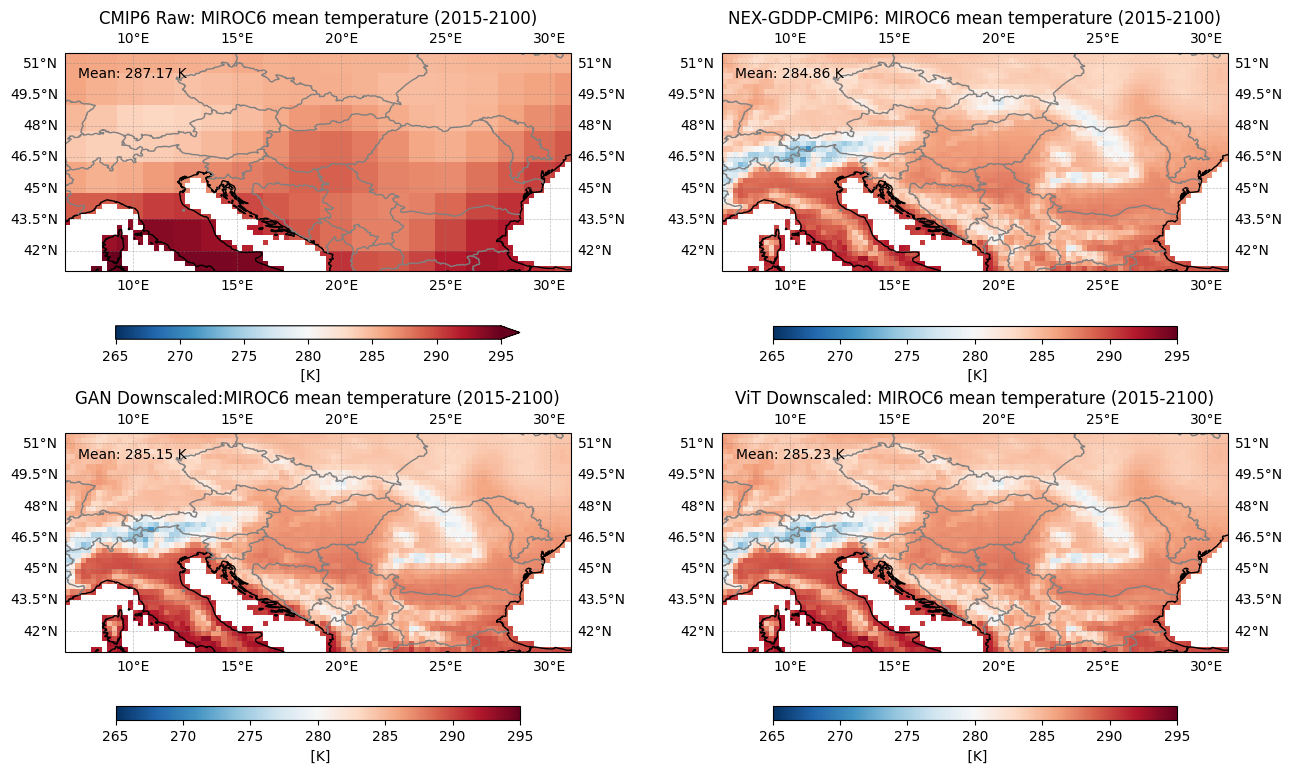

In [15]:
# Define file paths for SSP245 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp245/r1i1p1f1/tas/tas_day_MIROC6_ssp245_r1i1p1f1_gn_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp245/r1i1p1f1/tas/tas_day_MIROC6_ssp245_r1i1p1f1_gr_2015_2100_rou.zarr'
vit_ssp_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp245/r1i1p1f1/tas/tas_day_vit_MIROC6_ssp245_r1i1p1f1_gr_2015_2100_rou.nc'
gan_ssp_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp245/r1i1p1f1/tas/tas_day_gan_MIROC6_ssp245_r1i1p1f1_gr_2015_2100_rou.nc'

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load gan and ViT downscaled data for SSP245
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP245 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw: MIROC6 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values, vmin = 265, vmax = 295)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6: MIROC6 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values, vmin = 265, vmax = 295)
plot_map(gan_mean_ssp, axs[1, 0], 'GAN Downscaled:MIROC6 mean temperature (2015-2100)',gan_mean_ssp.mean().values, vmin = 265, vmax = 295)
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled: MIROC6 mean temperature (2015-2100)', vit_mean_ssp.mean().values, vmin = 265, vmax = 295)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

#### Climat change signal
Here the changes are computed for the 2071-2100 mean against the 1981-2100.

In [ ]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon

# Load CMIP6 data and interpolate to observational resolution
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)

# Load gan and ViT downscaled historical data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
gan_mean_hist = load_and_mean_data(gan_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load gan and Vit downscaled data for SSP245
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
gan_mean_change = gan_mean_ssp - gan_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=1.5, vmax=5, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=5, vmax=3, cmap='Reds')
plot_map(gan_mean_change, axs[1, 0], 'GAN: mean temperature difference (2071 - 2100 vs 1981 - 2010)', gan_mean_change.mean().values, vmin=1.5, vmax=5, cmap='Reds')
plot_map(vit_mean_change, axs[1, 1], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=1.5, vmax=5, cmap='Reds')

#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:

# --- Example Usage ---
#Assuming the following variables exist and are xarray.DataArrays loaded previously:
cmip6_change
nexgddp_mean_change
vit_mean_change
gan_mean_change

# --- Call the function with custom title and xlabel ---
custom_plot_title = "PDF of Changes in Air temperature - SSP245)"
custom_x_label = "Change in Air temperature [K]"

plot_relative_change_pdfs(
    cmip6_change,
    nexgddp_mean_change,
    vit_mean_change,
    gan_mean_change,
    # Pass title and xlabel as keyword arguments
    title=custom_plot_title,
    xlabel=custom_x_label,
    # Other optional arguments can also be passed
    figsize=(8, 6),
    percentile_range=(1, 99) # Use a slightly different range
)

#### Calculate RMSE and MAE for SSP245 and plot time series of the annual and montly global mean for the selected domain

Calculate the RMSE and MAE between the downscaled models (NEX-GDDP, GAN and ViT) and the CMIP6 raw data for the SSP245 scenario, for yearly data for all pixels from the domain.

In [ ]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load and process gan data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
                      calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values))

nexgddp_global_mean, cmip6_global_mean, gan_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"GAN: RMSE = {rmse_gan:.3f}, MAE = {mae_gan:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")


# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('Historical - Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature [°K]', fontsize=16)
plt.legend()
plt.grid()
# Set tick font sizes
# Set specific x-axis ticks and font size
plt.xticks(ticks=[2015, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], rotation=45, fontsize=16)

plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [283.05, 282.80, 282.55]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP', 'GAN', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2031, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2071, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2031, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2071, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(282.5, 288)
plt.xlim(2013,2102)
plt.tight_layout()
plt.show()

#### Print accuracy metrics for each month

In [ ]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
cmip6_monthly = load_and_process(cmip6_ssp_file) 
gan_monthly = load_and_process(gan_ssp_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
gan_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

#### Boxplots

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[1],
    datasets[2],
    datasets[3],
    month_names,
    gmfd = None
)

#### Plot January and July

In [ ]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='gan Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### SSP 585

In [ ]:
# Define file paths for SSP585 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp585/r1i1p1f1/tas/tas_day_MIROC6_ssp585_r1i1p1f1_gn_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp585/r1i1p1f1/tas/tas_day_MIROC6_ssp585_r1i1p1f1_gr_2015_2100_rou.zarr'
vit_ssp_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp585/r1i1p1f1/tas/tas_day_vit_MIROC6_ssp585_r1i1p1f1_gr_2015_2100_rou.nc'
gan_ssp_file = '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp585/r1i1p1f1/tas/tas_day_gan_MIROC6_ssp585_r1i1p1f1_gr_2015_2100_rou.nc'

# Load NEX-GDDP SSP585 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP585 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load gan and ViT downscaled data for SSP585
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP585 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw:MIROC6 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values, vmin = 265, vmax = 295)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6:MIROC6 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values, vmin = 265, vmax = 295)
plot_map(gan_mean_ssp, axs[1, 0], 'GAN Downscaled:MIROC6 mean temperature (2015-2100)',gan_mean_ssp.mean().values, vmin = 265, vmax = 295)
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled:MIROC6 mean temperature (2015-2100)', vit_mean_ssp.mean().values, vmin = 265, vmax = 295)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

##### Climate change signal

In [ ]:
# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load gan and Vit downscaled data for SSP245
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
gan_mean_change = gan_mean_ssp - gan_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=5, vmax=8, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=5, vmax=8, cmap='Reds')
plot_map(gan_mean_change, axs[1, 0], 'GAN: mean temperature difference (2071 - 2100 vs 1981 - 2010)', gan_mean_change.mean().values, vmin=5, vmax=8, cmap='Reds')
plot_map(vit_mean_change, axs[1, 1], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=5, vmax=8, cmap='Reds')

#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:

# --- Example Usage ---
#Assuming the following variables exist and are xarray.DataArrays loaded previously:
cmip6_change
nexgddp_mean_change
vit_mean_change
gan_mean_change

# --- Call the function with custom title and xlabel ---
custom_plot_title = "PDF of Changes in Air temperature - SSP585)"
custom_x_label = "Change in Air temperature [K]"

plot_relative_change_pdfs(
    cmip6_change,
    nexgddp_mean_change,
    vit_mean_change,
    gan_mean_change,
    # Pass title and xlabel as keyword arguments
    title=custom_plot_title,
    xlabel=custom_x_label,
    # Other optional arguments can also be passed
    figsize=(8, 6),
    percentile_range=(1, 99) # Use a slightly different range
)

##### Print accuracy indicators for each month

In [ ]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly


nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
cmip6_monthly = load_and_process(cmip6_ssp_file) 
gan_monthly = load_and_process(gan_ssp_file, var_name='tas_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
gan_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

In [ ]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load and process gan data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
                      calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values))

nexgddp_global_mean, cmip6_global_mean, gan_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"GAN: RMSE = {rmse_gan:.3f}, MAE = {mae_gan:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")


# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('Historical - Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature [°K]', fontsize=16)
plt.legend()
plt.grid()
# Set tick font sizes
# Set specific x-axis ticks and font size
plt.xticks(ticks=[2015, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], rotation=45, fontsize=16)

plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [283.35, 282.95, 282.55]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP', 'GAN', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2039, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2071, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2039, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2071, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(282, 294)
plt.xlim(2013,2102)
plt.tight_layout()
plt.show()

#### Boxplots

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[1],
    datasets[2],
    datasets[3],
    month_names,
    gmfd = None
)

#### Plots January and July

In [ ]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='gan Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## Precipitation

### Load and plot historical
Load the datasets (CMIP6, NEX-GDDP,GAN and ViT), calculate the multiannual means, and plot the results.

In [ ]:
# Define file paths for historical data
directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6/historical/r1i1p1f1/pr/'
# List all .nc files in the directory (non-recursive)
nexgddp_hist_files  = glob.glob(f'{directory}/*.nc')

cmip6_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/MIROC6'
cmip6_hist_file = f'{cmip6_base_path}/historical/r1i1p1f1/pr/pr_day_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.zarr'

vit_hist_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/historical/r1i1p1f1/pr/pr_day_vit_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.nc'
gan_hist_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/historical/r1i1p1f1/pr/pr_day_gan_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.nc'



# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'pr', start_year = 1950, end_year = 2014)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
nexgddp_mean_hist = nexgddp_mean_hist * 86400
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon


# Load CMIP6 data and interpolate
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1950, end_year = 2014)
cmip6_mean_hist = cmip6_mean_hist * 86400
# Load gan and ViT downscaled data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)

gan_mean_hist = load_and_mean_data(gan_hist_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)


# Load GMFD observatinal data
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/prcp_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_mean_hist = load_and_mean_data(gmfd_files, 'prcp', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)

gmfd_mean_hist = gmfd_mean_hist  * 86400

# Plot multiannual means for historical data
fig, axs = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Plot each dataset for historical data
plot_map(gmfd_mean_hist, axs[0, 0], 'GMFD - observational (1950-2014)', gmfd_mean_hist.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(cmip6_mean_hist, axs[0, 1], 'CMIP6 Raw:MIROC6 annual precipitation (1950-2014)', cmip6_mean_hist.mean().values,vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')

plot_map(gmfd_mean_hist, axs[1, 0], 'NEX-GDDP-CMIP6:MIROC6 annual precipitation (1950-2014)', gmfd_mean_hist.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
axs[1, 1].set_axis_off()
plot_map(gan_mean_hist, axs[2, 0], 'GAN Downscaled:MIROC6 annual precipitation (1950-2014)', gan_mean_hist.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(vit_mean_hist, axs[2, 1], 'ViT Downscaled:MIROC6 annual precipitation (1950-2014)', vit_mean_hist.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')

plt.show()

In [ ]:


# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_hist_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['pr'].resample(time='YE').sum(dim='time', skipna=False)
nexgddp_annual = nexgddp_annual * 86400

nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_hist_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})
cmip6_annual = cmip6_ds['pr'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
cmip6_annual = cmip6_annual * 86400
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


# Load GMFD observatinal data
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/prcp_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_ds = xr.open_mfdataset(gmfd_files, combine='by_coords', chunks={'time': -1})
gmfd_annual = gmfd_ds['prcp'].resample(time='YE').sum(dim='time').where(~mask_nexgddp_na)
gmfd_annual = gmfd_annual * 86400
gmfd_global_mean = gmfd_annual.mean(dim=['lat', 'lon'])



#Load and process GAN data
gan_ds = xr.open_dataset(gan_hist_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['pr_downscaled'].resample(time='YE').sum(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_hist_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['pr_downscaled'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])





# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean,gmfd_global_mean, gan_global_mean, vit_global_mean,
                       calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gmfd_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
                      calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values))

nexgddp_global_mean, cmip6_global_mean, gmfd_global_mean, gan_global_mean,  vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gmfd, mae_gmfd), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"GMFD: RMSE = {rmse_gmfd:.3f}, MAE = {mae_gmfd:.3f}")
print(f"GAN: RMSE = {rmse_gan:.3f}, MAE = {mae_gan:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")


# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gmfd_global_mean.values, label='GMFD', color='#969696', linestyle='--')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('Historical - Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=16)
plt.ylabel('Precipitation [mm]', fontsize=16)
plt.legend()
plt.grid()
# Set tick font sizes
# Set specific x-axis ticks and font size
plt.xticks(ticks=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2014], rotation=45, fontsize=16)

plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [1160, 1140, 1120, 1100]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp,rmse_gmfd, rmse_gan, rmse_vit],
        [mae_nexgddp,rmse_gmfd, mae_gan, mae_vit],
        ['NEX-GDDP', 'GMFD', 'GAN', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(1961, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(1991, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(1961, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(1991, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)

# Adjust subplot parameters for better layout
plt.ylim(600, 1200)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='pr', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').mean(dim='time')
    return monthly


nexgddp_monthly = load_and_process(nexgddp_hist_files) 
nexgddp_monthly = nexgddp_monthly * 86400

gmfd_monthly = load_and_process(gmfd_files, var_name='prcp') 
gmfd_monthly = gmfd_monthly.rename('pr')
gmfd_monthly = gmfd_monthly * 86400
cmip6_monthly = load_and_process(cmip6_hist_file) 

gan_monthly = load_and_process(gan_hist_file, var_name='pr_downscaled') 
vit_monthly = load_and_process(vit_hist_file, var_name='pr_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})
cmip6_monthly = cmip6_monthly * 86400
# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly,gmfd_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly,gmfd_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
gmfd_global_mean_monthly = global_means[1]
nexgddp_global_mean_monthly = global_means[2]
gan_global_mean_monthly = global_means[3]
vit_global_mean_monthly = global_means[4]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']



# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GMFD RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GMFD MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_gmfd, mae_gmfd = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[4].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["GMFD RMSE"].append(rmse_gmfd)
    metrics["GMFD MAE"].append(mae_gmfd)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'GMFD RMSE', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'GMFD MAE', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[2],
    datasets[3],
    datasets[4],
    month_names,
    gmfd = datasets[1],variable_name='Precipitation'
)

### SSP 126

In [ ]:
directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6/ssp126/r1i1p1f1/pr/'
# List all .nc files in the directory (non-recursive)
nexgddp_ssp_files  = glob.glob(f'{directory}/*.nc')
cmip6_ssp_file = f'{cmip6_base_path}/ssp126/r1i1p1f1/pr/pr_day_MIROC6_ssp126_r1i1p1f1_gr_2015_2100_rou.zarr'

vit_ssp_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp126/r1i1p1f1/pr/pr_day_vit_MIROC6_ssp126_r1i1p1f1_gr_2015_2100_rou.nc'
gan_ssp_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp126/r1i1p1f1/pr/pr_day_gan_MIROC6_ssp126_r1i1p1f1_gr_2015_2100_rou.nc'


# Load NEX-GDDP SSP126 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'pr', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
nexgddp_mean_ssp = nexgddp_mean_ssp * 86400

target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP126 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)
cmip6_mean_ssp = cmip6_mean_ssp * 86400
# Load gan and ViT downscaled data for SSP126
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP126 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw:MIROC6 annual precipitation (2015-2100)', cmip6_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6:MIROC6 annual precipitation (2015-2100)', nexgddp_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(gan_mean_ssp, axs[1, 0], 'GAN Downscaled:MIROC6 annual precipitation (2015-2100)',gan_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled:MIROC6 annual precipitation (2015-2100)', vit_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'pr', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon
nexgddp_mean_hist = nexgddp_mean_hist * 86400
# Load CMIP6 data and interpolate to observational resolution
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)
cmip6_mean_hist =  cmip6_mean_hist * 86400
# # Load GAN and ViT downscaled historical data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
gan_mean_hist = load_and_mean_data(gan_hist_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'pr', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon
nexgddp_mean_ssp = nexgddp_mean_ssp  * 86400
# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)
cmip6_mean_ssp = cmip6_mean_ssp  * 86400
# Load gan and Vit downscaled data for SSP245
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
# Optional: Relative change (percentage change) - see considerations below
cmip6_relative_change = (cmip6_change / cmip6_mean_hist) * 100
nexgddp_relative_change = (nexgddp_mean_change / nexgddp_mean_hist) * 100
vit_relative_change = (vit_mean_change / vit_mean_hist) * 100
gan_mean_change = gan_mean_ssp - gan_mean_hist
gan_relative_change = (gan_mean_change / gan_mean_hist) * 100

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_relative_change, axs[0, 0], 'CMIP6: mean precipitation difference (2071 - 2100 vs 1981 - 2010)', cmip6_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(nexgddp_relative_change, axs[0, 1], 'NEX-GDDP: mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', nexgddp_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(gan_relative_change, axs[1, 0], 'GAN: mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', gan_mean_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(vit_relative_change, axs[1, 1], 'ViT: mean mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', vit_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')

axs[1, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:

# --- Example Usage ---
#Assuming the following variables exist and are xarray.DataArrays loaded previously:
cmip6_relative_change
nexgddp_relative_change
vit_relative_change
gan_relative_change

# --- Call the function with custom title and xlabel ---
custom_plot_title = "PDF of Relative Changes in Precipitation - SSP126)"
custom_x_label = "Relative Change in Precipitation [%]"

plot_relative_change_pdfs(
    cmip6_relative_change,
    nexgddp_relative_change,
    vit_relative_change,
    gan_relative_change,
    # Pass title and xlabel as keyword arguments
    title=custom_plot_title,
    xlabel=custom_x_label,
    # Other optional arguments can also be passed
    figsize=(8, 6),
    percentile_range=(1, 99) # Use a slightly different range
)

#### Annual time serie plots

In [ ]:


# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['pr'].resample(time='YE').sum(dim='time', skipna=False)
nexgddp_annual = nexgddp_annual * 86400

nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})
cmip6_annual = cmip6_ds['pr'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
cmip6_annual = cmip6_annual * 86400
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


#Load and process GAN data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['pr_downscaled'].resample(time='YE').sum(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['pr_downscaled'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])


# Compute all values
results = dask.compute(
    nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
    calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values)
)

# Unpack results
nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values


# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.1f}")
print(f"GAN: RMSE = {rmse_gan:.1f}, MAE = {mae_gan:.1f}")
print(f"ViT: RMSE = {rmse_vit:.1f}, MAE = {mae_vit:.1f}")

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('SSP126 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=14)
plt.ylabel('Precipitation [mm]', fontsize=16)
plt.legend()
plt.grid()
plt.xticks(ticks=[2014,2020,2030,2040,2050,2060,2070, 2080, 2090, 2100], rotation=45, fontsize=16)
plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [1160, 1130, 1100]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP',  'GAN','ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2015, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2015, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.1f}', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.1f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(530, 1200)
plt.tight_layout()
plt.show()


#### Accuracy metrics for each month

In [ ]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='pr', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').sum(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
nexgddp_monthly = nexgddp_monthly * 86400
cmip6_monthly = load_and_process(cmip6_ssp_file) 

gan_monthly = load_and_process(gan_ssp_file, var_name='pr_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='pr_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})
cmip6_monthly = cmip6_monthly * 86400
# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
gan_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

#### Box-plots

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[1],
    datasets[2],
    datasets[3],
    month_names,
    gmfd = None,variable_name='Precipitation'
)

In [ ]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Precipitatin (°C)')
plt.title('Global Mean Precipitation in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Precipitation (°C)')
plt.title('Global Mean Precipitatin in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### SSP 245

In [ ]:
directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6/ssp245/r1i1p1f1/pr/'
# List all .nc files in the directory (non-recursive)
nexgddp_ssp_files  = glob.glob(f'{directory}/*.nc')
cmip6_ssp_file = f'{cmip6_base_path}/ssp245/r1i1p1f1/pr/pr_day_MIROC6_ssp245_r1i1p1f1_gr_2015_2100_rou.zarr'
vit_ssp_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp245/r1i1p1f1/pr/pr_day_vit_MIROC6_ssp245_r1i1p1f1_gr_2015_2100_rou.nc'
gan_ssp_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp245/r1i1p1f1/pr/pr_day_gan_MIROC6_ssp245_r1i1p1f1_gr_2015_2100_rou.nc'

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'pr', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon
nexgddp_mean_ssp = nexgddp_mean_ssp * 86400
# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)
cmip6_mean_ssp = cmip6_mean_ssp * 86400
# Load gan and ViT downscaled data for SSP245
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP245 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw:MIROC6 annual precipitation (2015-2100)', cmip6_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6:MIROC6 annual precipitation (2015-2100)', nexgddp_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(gan_mean_ssp, axs[1, 0], 'GAN Downscaled:MIROC6 annual precipitation (2015-2100)',gan_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu',  units = 'mm')
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled:MIROC6 annual precipitation (2015-2100)', vit_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu',  units = 'mm')
# Leave axs[0, 1] empty as requested
axs[1, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:
# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'pr', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon
nexgddp_mean_ssp = nexgddp_mean_ssp  * 86400
# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)
cmip6_mean_ssp = cmip6_mean_ssp  * 86400
# Load gan and Vit downscaled data for SSP245
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
# Optional: Relative change (percentage change) - see considerations below
cmip6_relative_change = (cmip6_change / cmip6_mean_hist) * 100
nexgddp_relative_change = (nexgddp_mean_change / nexgddp_mean_hist) * 100
vit_relative_change = (vit_mean_change / vit_mean_hist) * 100
gan_mean_change = gan_mean_ssp - gan_mean_hist
gan_relative_change = (gan_mean_change / gan_mean_hist) * 100

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_relative_change, axs[0, 0], 'CMIP6: mean precipitation difference (2071 - 2100 vs 1981 - 2010)', cmip6_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(nexgddp_relative_change, axs[0, 1], 'NEX-GDDP: mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', nexgddp_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(gan_relative_change, axs[1, 0], 'GAN: mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', gan_mean_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(vit_relative_change, axs[1, 1], 'ViT: mean mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', vit_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')

axs[1, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:


# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['pr'].resample(time='YE').sum(dim='time', skipna=False)
nexgddp_annual = nexgddp_annual * 86400

nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})
cmip6_annual = cmip6_ds['pr'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
cmip6_annual = cmip6_annual * 86400
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


#Load and process GAN data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['pr_downscaled'].resample(time='YE').sum(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['pr_downscaled'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])


# Compute all values
results = dask.compute(
    nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
    calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values)
)

# Unpack results
nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values


# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.1f}")
print(f"GAN: RMSE = {rmse_gan:.1f}, MAE = {mae_gan:.1f}")
print(f"ViT: RMSE = {rmse_vit:.1f}, MAE = {mae_vit:.1f}")

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('SSP126 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=14)
plt.ylabel('Precipitation [mm]', fontsize=16)
plt.legend()
plt.grid()
plt.xticks(ticks=[2014,2020,2030,2040,2050,2060,2070, 2080, 2090, 2100], rotation=45, fontsize=16)
plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [1160, 1130, 1100]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP',  'GAN','ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2015, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2015, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.1f}', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.1f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(530, 1200)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='pr', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').sum(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
nexgddp_monthly = nexgddp_monthly * 86400
cmip6_monthly = load_and_process(cmip6_ssp_file) 

gan_monthly = load_and_process(gan_ssp_file, var_name='pr_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='pr_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})
cmip6_monthly = cmip6_monthly * 86400
# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
gan_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[1],
    datasets[2],
    datasets[3],
    month_names,
    gmfd = None,variable_name='Precipitation'
)

In [ ]:


# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['pr'].resample(time='YE').sum(dim='time', skipna=False)
nexgddp_annual = nexgddp_annual * 86400

nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})
cmip6_annual = cmip6_ds['pr'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
cmip6_annual = cmip6_annual * 86400
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


#Load and process GAN data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['pr_downscaled'].resample(time='YE').sum(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['pr_downscaled'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])


# Compute all values
results = dask.compute(
    nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
    calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values)
)

# Unpack results
nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values


# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.1f}")
print(f"GAN: RMSE = {rmse_gan:.1f}, MAE = {mae_gan:.1f}")
print(f"ViT: RMSE = {rmse_vit:.1f}, MAE = {mae_vit:.1f}")

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('SSP126 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=14)
plt.ylabel('Precipitation [mm]', fontsize=16)
plt.legend()
plt.grid()
plt.xticks(ticks=[2014,2020,2030,2040,2050,2060,2070, 2080, 2090, 2100], rotation=45, fontsize=16)
plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [1160, 1130, 1100]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP',  'GAN','ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2015, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2015, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.1f}', fontsize=11)
        plt.text(2050, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.1f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(530, 1200)
plt.tight_layout()
plt.show()


### SSP 585

In [ ]:
directory = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/MIROC6/ssp585/r1i1p1f1/pr/'
# List all .nc files in the directory (non-recursive)
nexgddp_ssp_files  = glob.glob(f'{directory}/*.nc')
cmip6_ssp_file = f'{cmip6_base_path}/ssp585/r1i1p1f1/pr/pr_day_MIROC6_ssp585_r1i1p1f1_gr_2015_2100_rou.zarr'
vit_ssp_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp585/r1i1p1f1/pr/pr_day_vit_MIROC6_ssp585_r1i1p1f1_gr_2015_2100_rou.nc'
gan_ssp_file =  '/data/cristi/a/cristi/downscaled_data/cmip6/downscaled/RO_CMIP6_BC/MIROC6/ssp585/r1i1p1f1/pr/pr_day_gan_MIROC6_ssp585_r1i1p1f1_gr_2015_2100_rou.nc'

# Load NEX-GDDP SSP585 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'pr', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon
nexgddp_mean_ssp = nexgddp_mean_ssp * 86400
# Load CMIP6 SSP585 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)
cmip6_mean_ssp = cmip6_mean_ssp * 86400
# Load gan and ViT downscaled data for SSP585
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP585 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw:MIROC6 annual precipitation (2015-2100)', cmip6_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6:MIROC6 annual precipitation (2015-2100)', nexgddp_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu', units = 'mm')
plot_map(gan_mean_ssp, axs[1, 0], 'GAN Downscaled:MIROC6 annual precipitation (2015-2100)',gan_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu',  units = 'mm')
plot_map(vit_mean_ssp, axs[1, 1], 'ViT Downscaled:MIROC6 annual precipitation (2015-2100)', vit_mean_ssp.mean().values, vmin=300, vmax=1500, cmap='YlGnBu',  units = 'mm')
# Leave axs[0, 1] empty as requested
axs[1, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'pr', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon
nexgddp_mean_hist = nexgddp_mean_hist * 86400
# Load CMIP6 data and interpolate to observational resolution
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)
cmip6_mean_hist =  cmip6_mean_hist * 86400
# # Load GAN and ViT downscaled historical data
vit_mean_hist = load_and_mean_data(vit_hist_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
gan_mean_hist = load_and_mean_data(gan_hist_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'pr', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon
nexgddp_mean_ssp = nexgddp_mean_ssp  * 86400
# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'pr', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)
cmip6_mean_ssp = cmip6_mean_ssp  * 86400
# Load gan and Vit downscaled data for SSP245
gan_mean_ssp = load_and_mean_data(gan_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'pr_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist
# Optional: Relative change (percentage change) - see considerations below
cmip6_relative_change = (cmip6_change / cmip6_mean_hist) * 100
nexgddp_relative_change = (nexgddp_mean_change / nexgddp_mean_hist) * 100
vit_relative_change = (vit_mean_change / vit_mean_hist) * 100
gan_mean_change = gan_mean_ssp - gan_mean_hist
gan_relative_change = (gan_mean_change / gan_mean_hist) * 100

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_relative_change, axs[0, 0], 'CMIP6: mean precipitation difference (2071 - 2100 vs 1981 - 2010)', cmip6_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(nexgddp_relative_change, axs[0, 1], 'NEX-GDDP: mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', nexgddp_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(gan_relative_change, axs[1, 0], 'GAN: mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', gan_mean_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')
plot_map(vit_relative_change, axs[1, 1], 'ViT: mean mean precipitation difference difference (2071 - 2100 vs 1981 - 2010)', vit_relative_change.mean().values, vmin=-20, vmax=20, cmap='BrBG', units = '%')

axs[1, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

In [ ]:

# --- Example Usage ---
#Assuming the following variables exist and are xarray.DataArrays loaded previously:
cmip6_relative_change
nexgddp_relative_change
vit_relative_change
gan_relative_change

# --- Call the function with custom title and xlabel ---
custom_plot_title = "PDF of Relative Changes in Precipitation - SSP585)"
custom_x_label = "Relative Change in Precipitation [%]"

plot_relative_change_pdfs(
    cmip6_relative_change,
    nexgddp_relative_change,
    vit_relative_change,
    gan_relative_change,
    # Pass title and xlabel as keyword arguments
    title=custom_plot_title,
    xlabel=custom_x_label,
    # Other optional arguments can also be passed
    figsize=(8, 6),
    percentile_range=(1, 99) # Use a slightly different range
)

In [ ]:


# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['pr'].resample(time='YE').sum(dim='time', skipna=False)
nexgddp_annual = nexgddp_annual * 86400

nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})
cmip6_annual = cmip6_ds['pr'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
cmip6_annual = cmip6_annual * 86400
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])


#Load and process GAN data
gan_ds = xr.open_dataset(gan_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
gan_annual = gan_ds['pr_downscaled'].resample(time='YE').sum(dim='time').where(~mask_nexgddp_na)
gan_global_mean = gan_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['pr_downscaled'].resample(time='YE').sum(dim='time', skipna=False).where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])


# Compute all values
results = dask.compute(
    nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean,
    calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, gan_global_mean.values),
    calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values)
)

# Unpack results
nexgddp_global_mean, cmip6_global_mean, gan_global_mean, vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_gan, mae_gan), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values


# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.1f}")
print(f"GAN: RMSE = {rmse_gan:.1f}, MAE = {mae_gan:.1f}")
print(f"ViT: RMSE = {rmse_vit:.1f}, MAE = {mae_vit:.1f}")

plt.figure(figsize=(10, 6))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, gan_global_mean.values, label='GAN', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue', linestyle='--')

# Customize the plot
#plt.title('SSP126 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
#plt.xlabel('Year', fontsize=14)
plt.ylabel('Precipitation [mm]', fontsize=16)
plt.legend()
plt.grid()
plt.xticks(ticks=[2014,2020,2030,2040,2050,2060,2070, 2080, 2090, 2100], rotation=45, fontsize=16)
plt.yticks(fontsize=16)


# Adjust text_y_positions to have enough elements
text_y_positions = [1210, 1180, 1150]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_gan, rmse_vit],
        [mae_nexgddp, mae_gan, mae_vit],
        ['NEX-GDDP',  'GAN','ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2031, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2065, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2031, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.1f}', fontsize=11)
        plt.text(2065, text_y_positions[i], f'MAE {label} vs. CMIP6 Raw: {mae:.1f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(530, 1250)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='pr', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='1ME').sum(dim='time')
    return monthly

# Convert Kelvin to Celsius
nexgddp_monthly = load_and_process(nexgddp_ssp_files) 
nexgddp_monthly = nexgddp_monthly * 86400
cmip6_monthly = load_and_process(cmip6_ssp_file) 

gan_monthly = load_and_process(gan_ssp_file, var_name='pr_downscaled') 
vit_monthly = load_and_process(vit_ssp_file, var_name='pr_downscaled')

# Interpolate CMIP6 data to NEX-GDDP grid
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})
cmip6_monthly = cmip6_monthly * 86400
# Create a combined NaN mask across all datasets
combined_mask = np.logical_or.reduce([ds.isnull() for ds in [nexgddp_monthly, cmip6_monthly, gan_monthly, vit_monthly]])

# Apply the mask to all datasets
datasets = [ds.where(~combined_mask, np.nan) for ds in [cmip6_monthly, nexgddp_monthly, gan_monthly, vit_monthly]]

# Compute global means
global_means = [ds.mean(dim=['lat', 'lon']) for ds in datasets]

# Extract the global means for each dataset
cmip6_global_mean_monthly = global_means[0]
nexgddp_global_mean_monthly = global_means[1]
gan_global_mean_monthly = global_means[2]
vit_global_mean_monthly = global_means[3]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "GAN RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "GAN MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[0].values[month_mask], datasets[1].values[month_mask])
    rmse_gan, mae_gan = calculate_rmse_mae(datasets[0].values[month_mask], datasets[2].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[0].values[month_mask], datasets[3].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["GAN RMSE"].append(rmse_gan)
    metrics["GAN MAE"].append(mae_gan)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE','GAN RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE','GAN MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

In [ ]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
create_single_panel_boxplot(
    datasets[0],
    datasets[1],
    datasets[2],
    datasets[3],
    month_names,
    gmfd = None,variable_name='Precipitation'
)

In [ ]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Precipitatin (°C)')
plt.title('Global Mean Precipitation in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 8)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 8)
gan_january = gan_global_mean_monthly.sel(time=gan_global_mean_monthly['time.month'] == 8)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 8)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(gan_january['time'], gan_january, label='GAN Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Precipitation (°C)')
plt.title('Global Mean Precipitatin in July for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
